# Common

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from typing import Optional
import pickle

def train_epoch(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    lambda_ : Optional[float]=None,
    beta : Optional[float]=None
):
    """
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load the batch
    a single batch and zero the optimizer. Then we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    """

    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        loss = F.cross_entropy(output, target)

        # compute the gradients
        loss.backward()

        # perform the gradient step
        optimizer.step()

        if beta is not None:
          with torch.no_grad():
            for name, param in model.named_parameters():
                if 'weight' in name:  # Apply only to weights, not biases
                    # Apply soft thresholding
                    param.sub_(param.sign() * LEARNING_RATE * lambda_)
                    param.data = torch.relu(param.abs() - beta * lambda_).sign() * param

        # print statistics
        running_loss += loss.item()

    return running_loss / len(train_dataloader)

def count_nonzero_params(model):
    nonzero_params = {}
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if it's a weight parameter and exclude biases and other parameters
            if 'weight' in name:
                nonzero = torch.count_nonzero(param.data).item()
                nonzero_params[name] = nonzero
    return nonzero_params


def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    PATH,
    lambda_ : Optional[float]=None,
    beta : Optional[float]=None,
    valid_dataloader: Optional[DataLoader]=None):
    '''
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accs = []
    layer_nonzeros = {name: [] for name, _ in model.named_parameters() if 'weight' in name}

    for epoch in range(epochs):
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device,
            lambda_ = lambda_ ,
            beta = beta,
        )
        train_losses.append(train_loss)
        nonzeros = count_nonzero_params(model)
        for name in layer_nonzeros.keys():
            layer_nonzeros[name].append(nonzeros.get(name, 0))
        if valid_dataloader is not None:
            valid_loss, valid_acc = predict(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

        if valid_dataloader is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Validation Loss={valid_loss:.4f}, Validation acc={valid_acc:.4f}")
    torch.save(model.state_dict(), '/content/ ' + PATH + '.pth')
    file = open('/content/ ' + PATH + 'losses' + '.pth','wb')
    pickle.dump({'train_losses': train_losses , 'valid_losses': valid_losses, 'valid_accs': valid_accs, 'layer_nonzeros': layer_nonzeros} , file)
    file.close()
    return train_losses, valid_losses, valid_accs, layer_nonzeros


def predict(
    model: nn.Module, test_dataloader: DataLoader, device: torch.device, verbose=True
):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target, reduction="sum")
            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_dataloader.dataset)
    accuracy = 100.0 * correct / len(test_dataloader.dataset)

    if verbose:
        print(
            f"Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.0f}%)"
        )

    return test_loss, accuracy


def visualize_images(dataloader):
    images = next(iter(dataloader))[0][:10]
    grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

    def show(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")

    show(grid)


def plot_loss(losses, ylim=None):
    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim(ylim)
    plt.title("Loss progression across epochs")

def plot_conv_filters(model, name):
    # Retrieve the convolutional layer's weights
    conv1_weight = model.conv1.weight.data.clone().cpu()

    # Normalize the weights
    conv1_weight = (conv1_weight - conv1_weight.min()) / (conv1_weight.max() - conv1_weight.min())

    # Get the number of filters and the number of channels
    num_filters = conv1_weight.size(0)
    num_channels = conv1_weight.size(1)
    print(num_filters)
    # Create subplots - assuming we have 3 channels (RGB)
    fig, axes = plt.subplots(ncols=4, nrows=2)

    for i in range(8):

            # Get the filter for the ith filter and jth channel
            f = conv1_weight[i, :].permute(1,2,0)
            axes[i//4, i%4].imshow(f, cmap='brg')
            axes[i//4, i%4].axis('off')

    # Show the plot
    plt.savefig(name+ '.png')
    plt.show()
    


In [3]:

class S_CONV(nn.Module):
    def __init__(self, alpha, output):
        super(S_CONV, self).__init__()
        # Convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=alpha, kernel_size=9, stride=2, padding=4)
        self.bn1 = nn.BatchNorm2d(alpha)

        # CIFAR-10 images are 32x32, after a 9x9 convolution with stride 2 and no padding, the output size will be:
        # output size = (input size - filter size + 2 * padding) / stride + 1
        # output size = (32 - 9 + 0) / 2 + 1 = 12
        # so the output will be 12x12 feature maps per channel
        conv_output_size = alpha * 16 * 16

        # Fully connected layers
        self.fc1 = nn.Linear(conv_output_size, 24 * alpha)
        self.bn2 = nn.BatchNorm1d(24 * alpha)
        self.fc2 = nn.Linear(24 * alpha, output)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layers
        x = self.fc1(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [4]:
class S_LOCAL(nn.Module):
    def __init__(self, alpha, output):
        super(S_LOCAL, self).__init__()
        # Locally connected layer simulated by a grouped convolutional layer
        # Each input channel is connected to its own set of filters with groups which simulates locality
        self.local_conv1 = nn.Conv2d(in_channels= 3, out_channels=3*alpha, kernel_size=9, stride=2, padding=4, groups= 3)
        self.bn1 = nn.BatchNorm2d(3*alpha)

        local_conv_output_size = 3*alpha * 16 * 16

        # The rest of the fully connected layers remain the same
        self.fc1 = nn.Linear(local_conv_output_size, 24 * alpha)
        self.bn2 = nn.BatchNorm1d(24 * alpha)
        self.fc2 = nn.Linear(24 * alpha, output)

    def forward(self, x):
        x = self.local_conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layers
        x = self.fc1(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [6]:
class S_FC(nn.Module):
    def __init__(self, alpha,output):
        super(S_FC, self).__init__()
        # Calculate the size of the input when flattened
        # CIFAR-10 images are 32x32 with 3 channels
        input_size = 3 * 32 * 32

        # Fully connected layers replacing the convolution
        # The input size is the flattened CIFAR-10 image size
        self.fc1 = nn.Linear(input_size, int(alpha*32*32*0.25))
        self.bn1 = nn.BatchNorm1d(int(alpha*32*32*0.25))

        # The rest of the fully connected layers remain the same
        self.fc2 = nn.Linear(int(alpha*32*32*0.25), 24 * alpha)
        self.bn2 = nn.BatchNorm1d(24 * alpha)
        self.fc3 = nn.Linear(24 * alpha, output)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the tensor right away for fully connected layers
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [7]:
class FC_3(nn.Module):
    def __init__(self, alpha,output):
        super(FC_3, self).__init__()
        # Calculate the size of the input when flattened
        # CIFAR-10 images are 32x32 with 3 channels
        input_size = 3 * 32 * 32

        # Fully connected layers replacing the convolution
        # The input size is the flattened CIFAR-10 image size
        self.fc1 = nn.Linear(input_size, alpha)
        self.bn1 = nn.BatchNorm1d(alpha)

        # The rest of the fully connected layers remain the same
        self.fc2 = nn.Linear(alpha, alpha)
        self.fc3 = nn.Linear(alpha, output)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the tensor right away for fully connected layers
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [8]:
# define the hyperparameters
BATCH_SIZE = 512
TEST_BATCH_SIZE = 512
LEARNING_RATE = 0.1
ALPHA = 64
##epoch size 400 or 4000
EPOCHS = 100
# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# for Mac users with M1 chip, use this line instead
#DEVICE = torch.device("mps")
print(DEVICE)

cpu


64


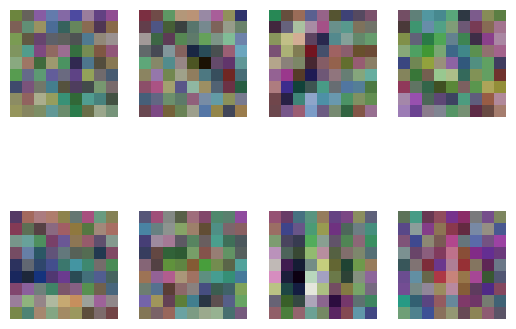

In [9]:
CIFAR10_CONV = S_CONV(alpha=ALPHA, output = 10).to(DEVICE)
CIFAR10_CONV.load_state_dict(torch.load('_SCONV_SGD_CIFAR10 (1).pth',map_location=torch.device('cpu')))
plot_conv_filters(CIFAR10_CONV, 'CIFAR10_CONV')
#predict(model=model_loaded, test_dataloader=test_dataloader, device=DEVICE)


64


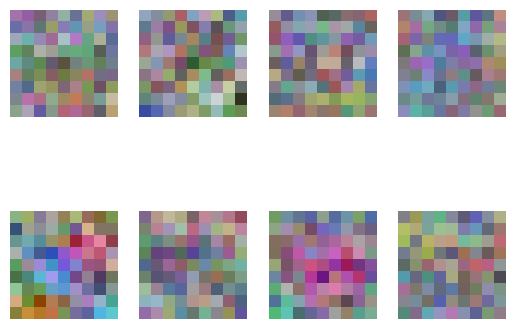

In [10]:
CIFAR100_CONV = S_CONV(alpha=ALPHA, output = 100).to(DEVICE)
CIFAR100_CONV.load_state_dict(torch.load('_SCONV_SGD_CIFAR100.pth',map_location=torch.device('cpu')))
plot_conv_filters(CIFAR100_CONV, 'CIFAR100_CONV')
#predict(model=model_loaded, test_dataloader=test_dataloader, device=DEVICE)

64


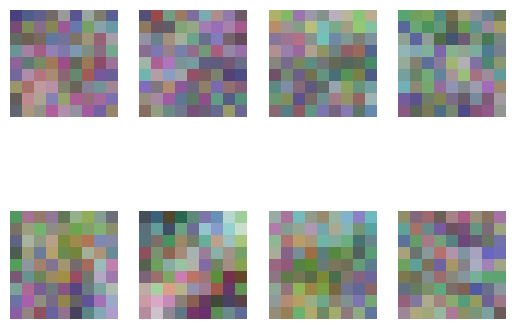

In [11]:
SVHN_CONV = S_CONV(alpha=ALPHA, output = 10).to(DEVICE)
SVHN_CONV.load_state_dict(torch.load('SCONV_SGD_SVHN.pth',map_location=torch.device('cpu')))
plot_conv_filters(SVHN_CONV, 'SVHN_CONV')

In [29]:
def visualize_fc_layer_weights(model, image_height=32, image_width=32, image_channels=3):
    # Extract the weights from the first fully connected layer
    fc_weights = model.fc1.weight.data.clone().cpu()
    
    # The weights are of shape (out_features, in_features)
    # Reshape in_features back to (image_channels, image_height, image_width)
    reshaped_weights = fc_weights.view(-1, image_channels, image_height, image_width)
    
    # Normalize the weights to [0, 1] for visualization
    reshaped_weights = (reshaped_weights - reshaped_weights.min()) / (reshaped_weights.max() - reshaped_weights.min())
    
    # Get the number of filters (neurons)
    num_filters = [2,4]
    
    # Plot each filter
    fig, axes = plt.subplots((num_filters[0]), (num_filters[1]))
    for i, ax in enumerate(axes.flat):
        if i < 8:
            # Select the first channel for visualization if multiple channels
            filter = reshaped_weights[i][0]
            ax.imshow(filter, cmap='hot')
            ax.axis('off')
    plt.show()

# Call this function with your model


In [14]:
import matplotlib.colors as mcolors

def visualize_fc_layer_weights2(model,  name, image_height=32, image_width=32, image_channels=3):
    # Extract the weights from the first fully connected layer
    fc_weights = model.fc1.weight.data.clone().cpu()

    # The weights are of shape (out_features, in_features)
    # Reshape in_features back to (image_channels, image_height, image_width)
    reshaped_weights = fc_weights.view(-1, image_channels, image_height, image_width)
    reshaped_weights = torch.abs(reshaped_weights)
    # Create a custom colormap with transparency for zero values
    # Here we use the 'hot' colormap as a base and create a new colormap that adds transparency
    colors = plt.cm.hot(np.linspace(0, 1, 256))
    colors[0, :] = (0, 0, 0, 0)  # Fully transparent for the zero value
    custom_cmap = mcolors.ListedColormap(colors)
    
    # Get the number of filters (neurons)
    num_filters = [2, 4]
    
    # Plot each filter
    fig, axes = plt.subplots(num_filters[0], num_filters[1])
    for i, ax in enumerate(axes.flat):
        if i < 8:
            # Select the first channel for visualization if multiple channels
            filter = reshaped_weights[i][0]
            # Normalize the filter to the range [0, 1] for visualization
            filter_normalized = (filter - filter.min()) / (filter.max() - filter.min())
            ax.imshow(filter_normalized, cmap='hot')
            ax.axis('off')
    print(filter)        
    plt.savefig(name +'.png')
    plt.show()

# Call this function with your model


tensor([[0.0160, 0.0144, 0.0063,  ..., 0.0041, 0.0078, 0.0058],
        [0.0097, 0.0126, 0.0058,  ..., 0.0037, 0.0010, 0.0120],
        [0.0091, 0.0002, 0.0174,  ..., 0.0064, 0.0166, 0.0028],
        ...,
        [0.0176, 0.0156, 0.0140,  ..., 0.0152, 0.0163, 0.0169],
        [0.0111, 0.0110, 0.0080,  ..., 0.0013, 0.0004, 0.0095],
        [0.0074, 0.0009, 0.0122,  ..., 0.0041, 0.0167, 0.0025]])


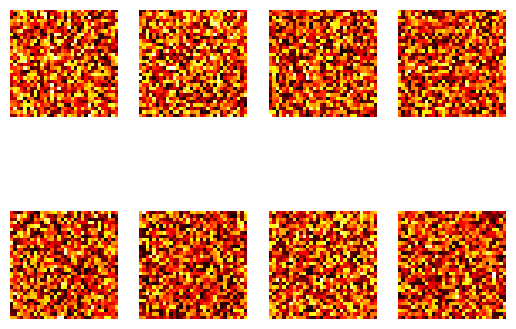

In [15]:
CIFAR10_FCSGD = S_FC(alpha=28, output = 10).to(DEVICE)
CIFAR10_FCSGD.load_state_dict(torch.load('_S_FC_SGD_CIFAR10 (1).pth',map_location=torch.device('cpu')))
visualize_fc_layer_weights2(CIFAR10_FCSGD, 'CIFAR10_FCSGD')

tensor([[0.0014, 0.0123, 0.0059,  ..., 0.0014, 0.0154, 0.0035],
        [0.0101, 0.0120, 0.0127,  ..., 0.0125, 0.0134, 0.0078],
        [0.0096, 0.0003, 0.0000,  ..., 0.0021, 0.0000, 0.0109],
        ...,
        [0.0000, 0.0000, 0.0098,  ..., 0.0005, 0.0057, 0.0005],
        [0.0009, 0.0037, 0.0015,  ..., 0.0071, 0.0056, 0.0032],
        [0.0188, 0.0026, 0.0195,  ..., 0.0150, 0.0129, 0.0089]])


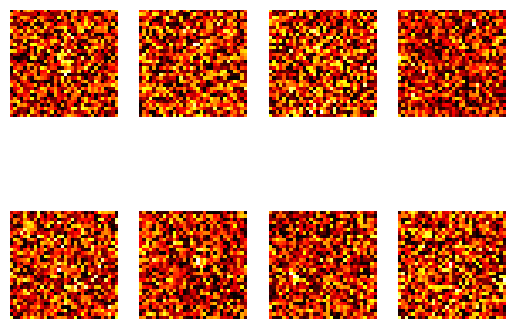

In [17]:
CIFAR10_FCB = S_FC(alpha=28, output = 10).to(DEVICE)
CIFAR10_FCB.load_state_dict(torch.load('_S_FC_b50_CIFAR10 (1).pth',map_location=torch.device('cpu')))
visualize_fc_layer_weights2(CIFAR10_FCB, 'CIFAR10_FCB')

tensor([[0.0060, 0.0018, 0.0011,  ..., 0.0109, 0.0007, 0.0183],
        [0.0091, 0.0121, 0.0161,  ..., 0.0107, 0.0031, 0.0134],
        [0.0017, 0.0039, 0.0148,  ..., 0.0083, 0.0151, 0.0085],
        ...,
        [0.0054, 0.0173, 0.0177,  ..., 0.0054, 0.0041, 0.0138],
        [0.0114, 0.0092, 0.0103,  ..., 0.0100, 0.0076, 0.0087],
        [0.0062, 0.0101, 0.0195,  ..., 0.0189, 0.0092, 0.0161]])


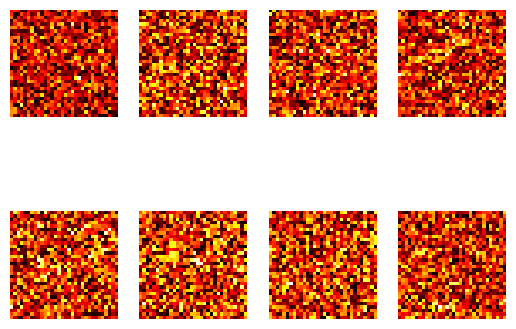

In [18]:
CIFAR100_FCSGD = S_FC(alpha=28, output = 100).to(DEVICE)
CIFAR100_FCSGD.load_state_dict(torch.load('_S_FC_SGD_CIFAR100.pth',map_location=torch.device('cpu')))
visualize_fc_layer_weights2(CIFAR100_FCSGD, 'CIFAR100_FCSGD')

tensor([[0.0000, 0.0055, 0.0000,  ..., 0.0058, 0.0014, 0.0000],
        [0.0000, 0.0000, 0.0070,  ..., 0.0014, 0.0016, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0060, 0.0012, 0.0011],
        ...,
        [0.0000, 0.0048, 0.0043,  ..., 0.0000, 0.0000, 0.0032],
        [0.0000, 0.0107, 0.0000,  ..., 0.0000, 0.0000, 0.0045],
        [0.0000, 0.0000, 0.0131,  ..., 0.0000, 0.0000, 0.0057]])


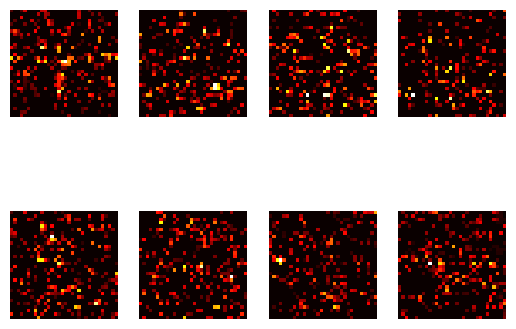

In [19]:
CIFAR100_FCB = S_FC(alpha=28, output = 100).to(DEVICE)
CIFAR100_FCB.load_state_dict(torch.load('_S_FC_b50_CIFAR100.pth',map_location=torch.device('cpu')))
visualize_fc_layer_weights2(CIFAR100_FCB, 'CIFAR100_FCB')

tensor([[0.0032, 0.0109, 0.0047,  ..., 0.0129, 0.0021, 0.0131],
        [0.0127, 0.0024, 0.0174,  ..., 0.0098, 0.0017, 0.0021],
        [0.0094, 0.0138, 0.0014,  ..., 0.0100, 0.0103, 0.0053],
        ...,
        [0.0198, 0.0126, 0.0025,  ..., 0.0109, 0.0119, 0.0075],
        [0.0004, 0.0158, 0.0014,  ..., 0.0069, 0.0069, 0.0064],
        [0.0114, 0.0105, 0.0156,  ..., 0.0138, 0.0061, 0.0079]])


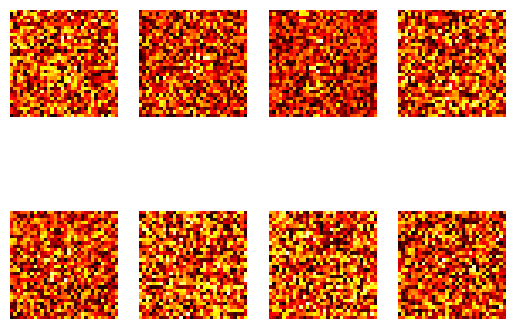

In [20]:
SVHN_FCSGD = S_FC(alpha=28, output = 10).to(DEVICE)
SVHN_FCSGD.load_state_dict(torch.load('S_FC_SGD_SVHN_epochs100.pth',map_location=torch.device('cpu')))
visualize_fc_layer_weights2(SVHN_FCSGD, 'SVHN_FCSGD')

tensor([[0.0093, 0.0021, 0.0096,  ..., 0.0106, 0.0095, 0.0012],
        [0.0013, 0.0081, 0.0134,  ..., 0.0039, 0.0040, 0.0047],
        [0.0062, 0.0030, 0.0012,  ..., 0.0007, 0.0001, 0.0069],
        ...,
        [0.0029, 0.0066, 0.0143,  ..., 0.0069, 0.0001, 0.0049],
        [0.0067, 0.0063, 0.0010,  ..., 0.0008, 0.0145, 0.0049],
        [0.0013, 0.0065, 0.0042,  ..., 0.0064, 0.0092, 0.0000]])


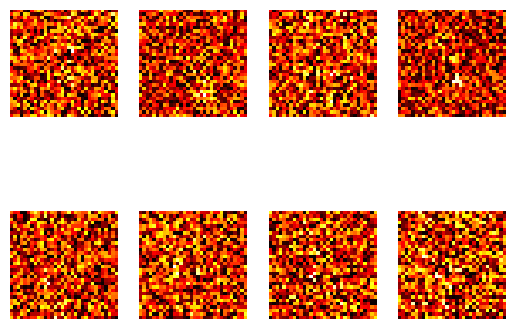

In [21]:
SVHN_FCB = S_FC(alpha=28, output = 10).to(DEVICE)
SVHN_FCB.load_state_dict(torch.load('S_FC_b50_SVHN_epochs100.pth',map_location=torch.device('cpu')))
visualize_fc_layer_weights2(SVHN_FCB, 'SVHN_FCB')